In [121]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys

np.set_printoptions(threshold=sys.maxsize)

In [122]:
def pixels_to_micrometers(pixels):
    known_pixels = 1920
    known_micrometers = 3659.269
    micrometers = (pixels * known_micrometers) / known_pixels
    return micrometers

In [123]:
def calculate_percentage_error(experimental_value, theoretical_value):
  return round(np.mean(np.abs((theoretical_value - experimental_value) / theoretical_value)) *100, 2)

In [124]:
def brighten(image):
  # convert to LAB and extract L  channel
  LAB = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
  L = LAB[:,:,0]
  # threshold L channel with triangle method
  value, thresh = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # threshold with adjusted value
  value = value + 10
  thresh = cv2.threshold(L, value, 255, cv2.THRESH_BINARY)[1]
  # invert threshold and make 3 channels
  thresh = 255 - thresh
  thresh = cv2.merge([thresh, thresh, thresh])
  gain = 2.5
  blue = cv2.multiply(image[:,:,0], gain)
  green = cv2.multiply(image[:,:,1], gain)
  red = cv2.multiply(image[:,:,2], gain)
  img_bright = cv2.merge([blue, green, red])
  # blend original and brightened using thresh as mask
  return np.where(thresh==255, img_bright, image)

In [125]:
def calculate_neck_properties(contour1, contour2):
  # Calculate the pairwise Euclidean distances between all points in the two contours
  distances = np.linalg.norm(contour1[:, None] - contour2, axis=-1)

  # Find the indices of the minimum distance in the distance matrix
  i, j = np.unravel_index(np.argmin(distances), distances.shape)
  
  # Get the nearest points
  nearest_points = (tuple(contour1[i]), tuple(contour2[j]))
  
  left_contour_rightmost_point = nearest_points[0]
  right_contour_leftmost_point = nearest_points[1]
  
  return pixels_to_micrometers(distances[i, j]), left_contour_rightmost_point, right_contour_leftmost_point

In [126]:
def collect_results(index, up_distance, down_distance, left_distance, right_distance, correct_values):
  results = []
  
  down_error = calculate_percentage_error(down_distance, correct_values['down'][index -1])
        
  results.append({'Image': index, 'Type': 'Down', 'Error': f'{down_error} %' })
  
  right_error = calculate_percentage_error(right_distance, correct_values['right'][index -1])
        
  results.append({'Image': index, 'Type': 'Right', 'Error': f'{right_error} %' })
  
  left_error = calculate_percentage_error(left_distance, correct_values['left'][index -1])
  
  results.append({'Image': index, 'Type': 'Left', 'Error': f'{left_error} %' })
  
  up_error = calculate_percentage_error(up_distance, correct_values['up'][index -1])
  
  results.append({'Image': index, 'Type': 'Up', 'Error': f'{up_error} %' })
  
  return results

In [127]:
def calculate_farthest_points(defects, contour):
  contour_farthest_points = [None, None]
  max_distances = [0, 0]
  
  for i in range(defects.shape[0]):
      s, e, f, d = defects[i, 0]
      far = tuple(contour[f])
      distance = d / 256  # Scale the distance
      if distance > max_distances[0]:
          max_distances[1] = max_distances[0]
          contour_farthest_points[1] = contour_farthest_points[0]
          max_distances[0] = distance
          contour_farthest_points[0] = far
      elif distance > max_distances[1]:
          max_distances[1] = distance
          contour_farthest_points[1] = far
          
  return contour_farthest_points

In [128]:
import random as rng
rng.seed(12345)

def process_image(img, index, correct_values):
    top_crop = 60
    bottom_crop = 70
    left_crop = 60
    right_crop = 60
    
    roi = img[top_crop:-bottom_crop, left_crop:-right_crop]
    
    brightened_image = brighten(roi)

    standard_imgray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    brightened_imgray = cv2.cvtColor(brightened_image, cv2.COLOR_BGR2GRAY)
    
    _, standard_thresh = cv2.threshold(
        standard_imgray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    _, brightened_thresh = cv2.threshold(
        brightened_imgray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    brightened_contours, hierarchy = cv2.findContours(
        brightened_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    standard_contours, hierarchy = cv2.findContours(
        standard_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    standard_filtered_contours = sorted(
        standard_contours, key=lambda x: cv2.contourArea(x), reverse=True)[:2]
    
    brightened_filtered_contours = sorted(
        brightened_contours, key=lambda x: cv2.contourArea(x), reverse=True)[:2]

    img_with_line = roi.copy()
    
    standard_contour1 = np.vstack(standard_filtered_contours[0])
    standard_contour2 = np.vstack(standard_filtered_contours[1])
    
    brightened_contour1 = np.vstack(brightened_filtered_contours[0])
    brightened_contour2 = np.vstack(brightened_filtered_contours[1])
    
    neck_distance, left_contour_rightmost_point, right_contour_leftmost_point = calculate_neck_properties(standard_contour1, standard_contour2)
    
    results = []
        
    neck_error = calculate_percentage_error(neck_distance, correct_values['neck'][index -1])
        
    results.append({'Image': index, 'Type': 'Neck', 'Error': f'{neck_error} %' })
    
    hull1 = cv2.convexHull(brightened_contour1, returnPoints=False)
    hull2 = cv2.convexHull(brightened_contour2, returnPoints=False)

    cv2.drawContours(img_with_line, brightened_filtered_contours, -1, (0, 255, 0), 3)
    
    hull_list = []
    for i in range(len(brightened_filtered_contours)):
        hull = cv2.convexHull(brightened_filtered_contours[i])
        hull_list.append(hull)

    if len(brightened_filtered_contours) >= 2:
        defects1 = cv2.convexityDefects(brightened_contour1, hull1)
        defects2 = cv2.convexityDefects(brightened_contour2, hull2)
        
        contour1_farthest_points = calculate_farthest_points(defects1, brightened_contour1)
        contour2_farthest_points = calculate_farthest_points(defects2, brightened_contour2)
        
        contour1_start, contour1_end = np.array(contour1_farthest_points[0]), np.array(contour1_farthest_points[1])
        contour2_start, contour2_end = np.array(contour2_farthest_points[0]), np.array(contour2_farthest_points[1])
        
        if contour1_start[1] < contour1_end[1]:
            contour1_start, contour1_end = contour1_end, contour1_start
        
        if contour2_start[1] < contour2_end[1]:
            contour2_start, contour2_end = contour2_end, contour2_start
        
        down_distance = pixels_to_micrometers(
            np.linalg.norm(contour1_end - contour2_end))
        
        up_distance = pixels_to_micrometers(
            np.linalg.norm(contour1_start - contour2_start))
        
        left_distance = pixels_to_micrometers(
            np.linalg.norm(contour1_start - contour1_end))

        right_distance = pixels_to_micrometers(
            np.linalg.norm(contour2_start - contour2_end))
        
        results += collect_results(index, down_distance, up_distance, left_distance, right_distance, correct_values)

        cv2.line(img_with_line, contour1_start, contour2_start, (255, 0, 0), 2)

        cv2.line(img_with_line, contour1_end, contour2_end, (255, 0, 0), 2)

        cv2.line(img_with_line, contour1_start, contour1_end, (255, 0, 0), 2)

        cv2.line(img_with_line, contour2_start, contour2_end, (255, 0, 0), 2)

        cv2.line(img_with_line, left_contour_rightmost_point, right_contour_leftmost_point, (0, 0, 255), 2)
    else:
        print("Insufficient number of filtered contours.")

    return img_with_line, results


In [129]:
def process_sequence(path, correct_values, output_file):
    loaded, imgs = cv2.imreadmulti(path)
    processed_images = []
    num_images = len(imgs)
    all_results = []

    for i, img in enumerate(imgs):
        img_with_line, results = process_image(imgs[i], i + 1, correct_values)
        all_results.extend(results)
        processed_images.append(img_with_line)    
    
    return all_results, processed_images

In [130]:
from correct_values.correct_3_percent import CORRECT_3_PERCENT_NECK, CORRECT_3_PERCENT_LEFT, CORRECT_3_PERCENT_RIGHT, CORRECT_3_PERCENT_UP, CORRECT_3_PERCENT_DOWN
from correct_values.correct_5_percent import CORRECT_5_PERCENT_NECK, CORRECT_5_PERCENT_LEFT, CORRECT_5_PERCENT_RIGHT, CORRECT_5_PERCENT_UP, CORRECT_5_PERCENT_DOWN
from correct_values.correct_16_percent import CORRECT_16_PERCENT_NECK, CORRECT_16_PERCENT_LEFT, CORRECT_16_PERCENT_RIGHT, CORRECT_16_PERCENT_UP, CORRECT_16_PERCENT_DOWN

In [131]:

IMAGES_DATA = [
    {
        'path': 'data/16%.tif',
        'values': {
            'right': CORRECT_16_PERCENT_RIGHT,
            'left': CORRECT_16_PERCENT_LEFT,
            'up': CORRECT_16_PERCENT_UP,
            'down': CORRECT_16_PERCENT_DOWN,
            'neck': CORRECT_16_PERCENT_NECK,
        }
    },
    {
        'path': 'data/5%.tif',
        'values': {
            'right': CORRECT_5_PERCENT_RIGHT,
            'left': CORRECT_5_PERCENT_LEFT,
            'up': CORRECT_5_PERCENT_UP,
            'down': CORRECT_5_PERCENT_DOWN,
            'neck': CORRECT_5_PERCENT_NECK,
        }
    },
    {
        'path': 'data/3%.tif',
        'values': {
            'right': CORRECT_3_PERCENT_RIGHT,
            'left': CORRECT_3_PERCENT_LEFT,
            'up': CORRECT_3_PERCENT_UP,
            'down': CORRECT_3_PERCENT_DOWN,
            'neck': CORRECT_3_PERCENT_NECK,
        }
    }
]


In [132]:
sequences_results = []
all_processed_images = []

for i in range(len(IMAGES_DATA)):
    image_data = IMAGES_DATA[i]
    sequence_results, processed_images = process_sequence(image_data['path'], image_data['values'], f'results/{image_data["path"].split("/")[1]}')
    sequences_results.append(sequence_results)
    all_processed_images.append(processed_images)

In [133]:
import pandas as pd

tables = []

for result in sequences_results:
  df = pd.DataFrame(result)

  table = df.pivot(index='Image', columns='Type', values='Error')
  tables.append(table)

In [134]:
from IPython.display import display_html

df1_styler = tables[0].style.set_table_attributes(
    "style='display:inline'").set_caption('16%')
df2_styler = tables[1].style.set_table_attributes(
    "style='display:inline'").set_caption('5%')
df3_styler = tables[2].style.set_table_attributes(
    "style='display:inline'").set_caption('3%')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_() +
             df3_styler._repr_html_(), raw=True)


Type,Down,Left,Neck,Right,Up
Image,,,,,
1,0.03 %,1.26 %,0.72 %,6.45 %,2.02 %
2,2.04 %,4.26 %,1.1 %,3.99 %,2.54 %
3,3.34 %,0.62 %,1.49 %,1.48 %,4.81 %
4,1.84 %,0.69 %,1.53 %,0.28 %,6.4 %
5,3.66 %,1.49 %,2.64 %,0.04 %,5.57 %
6,1.99 %,2.77 %,0.52 %,1.38 %,8.41 %
7,1.1 %,0.61 %,1.12 %,2.57 %,1.05 %
8,1.27 %,0.01 %,0.2 %,0.67 %,2.37 %
9,6.76 %,5.56 %,2.33 %,10.97 %,2.69 %


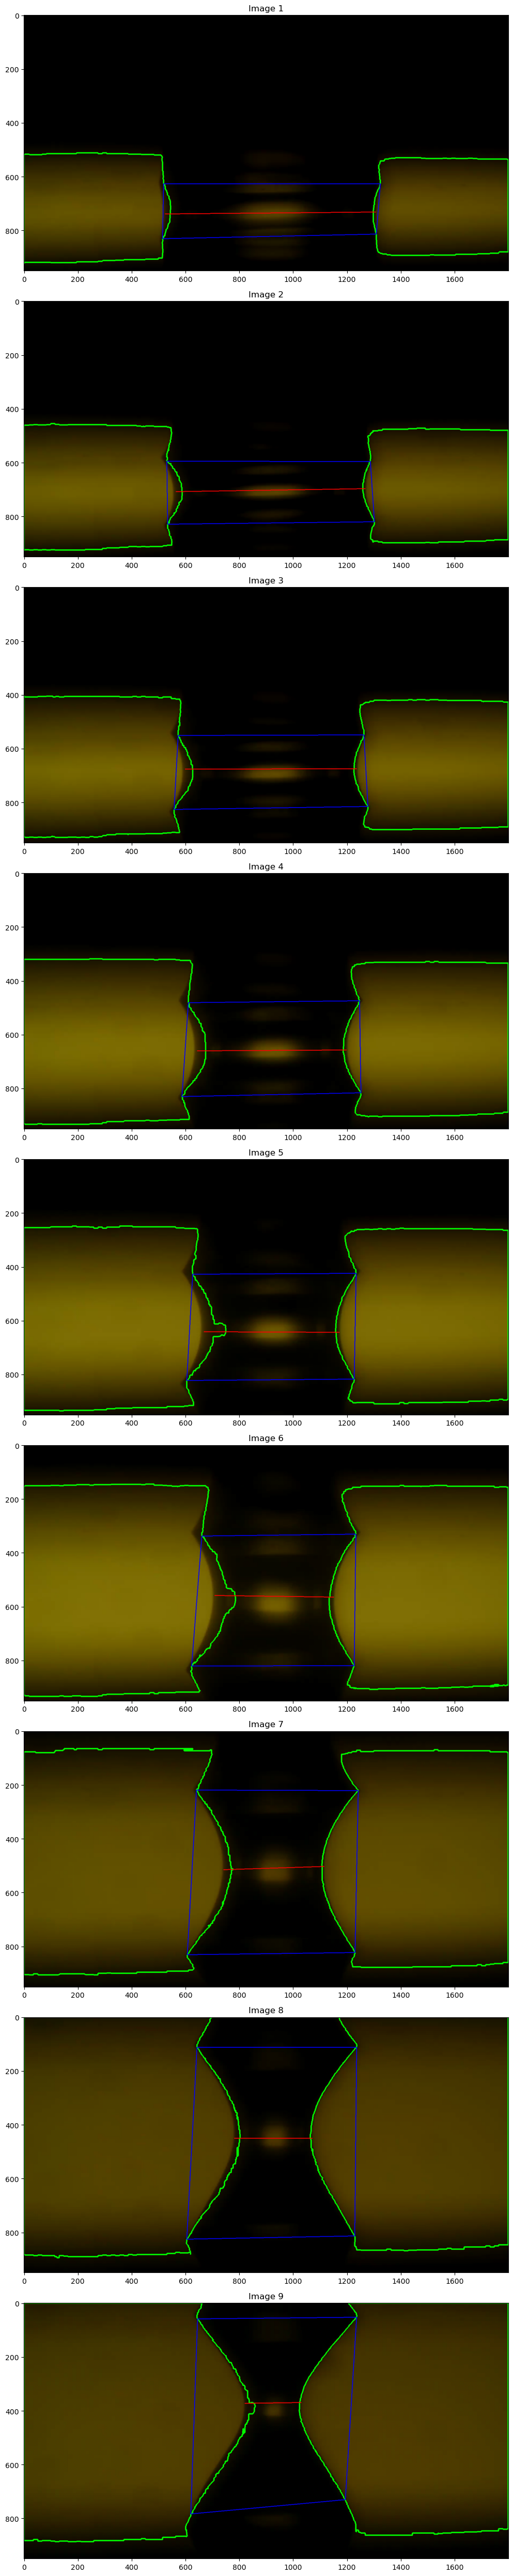

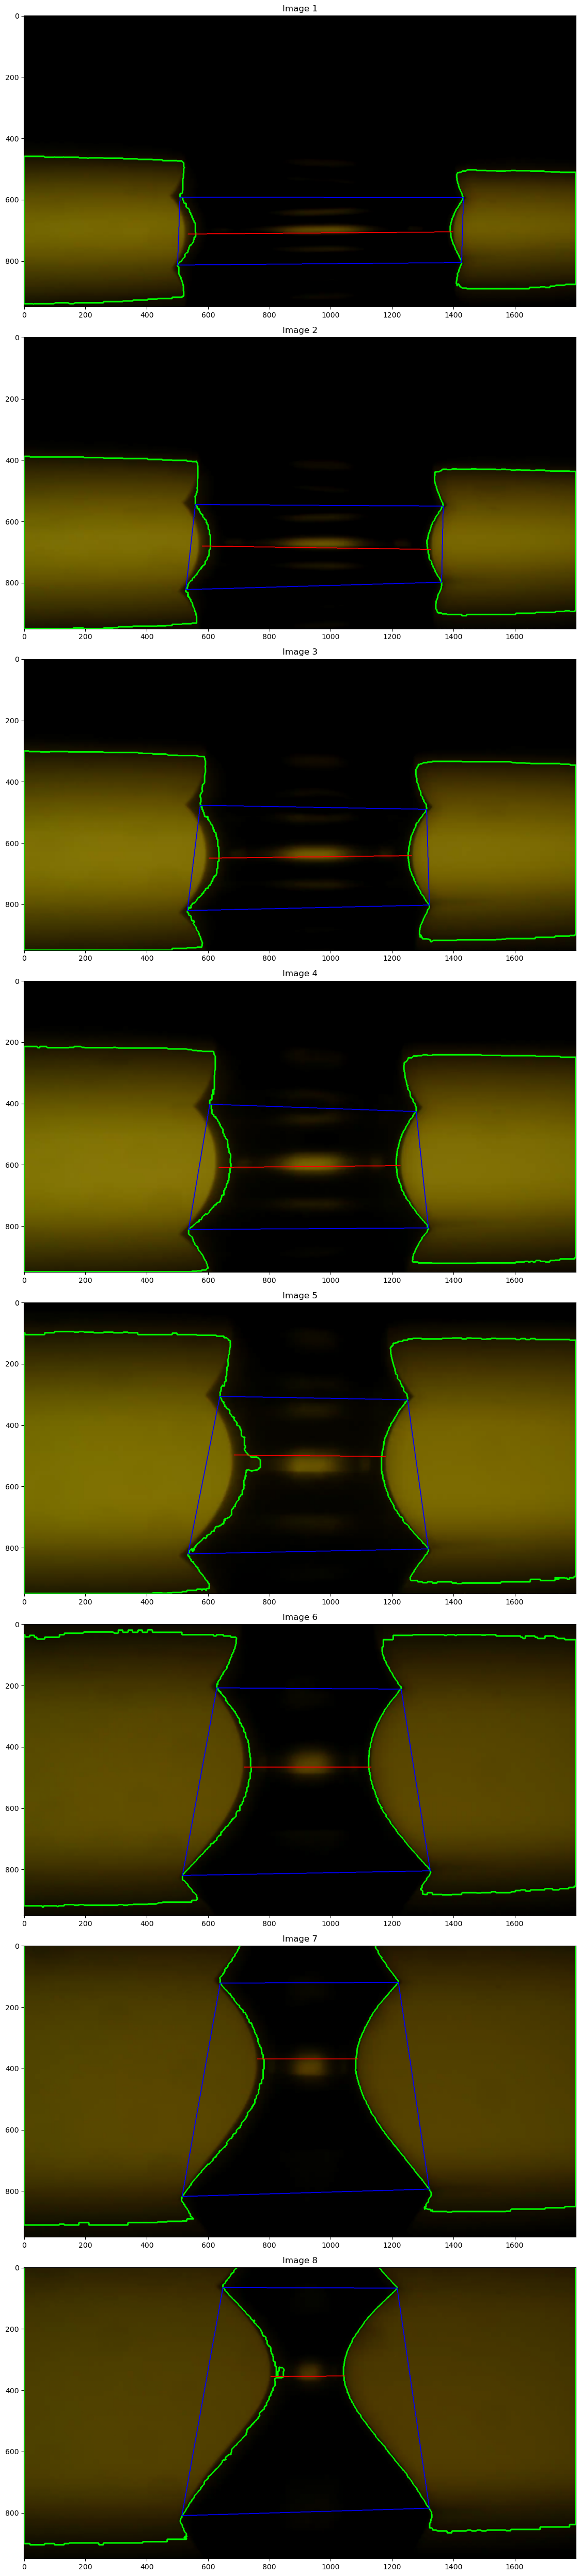

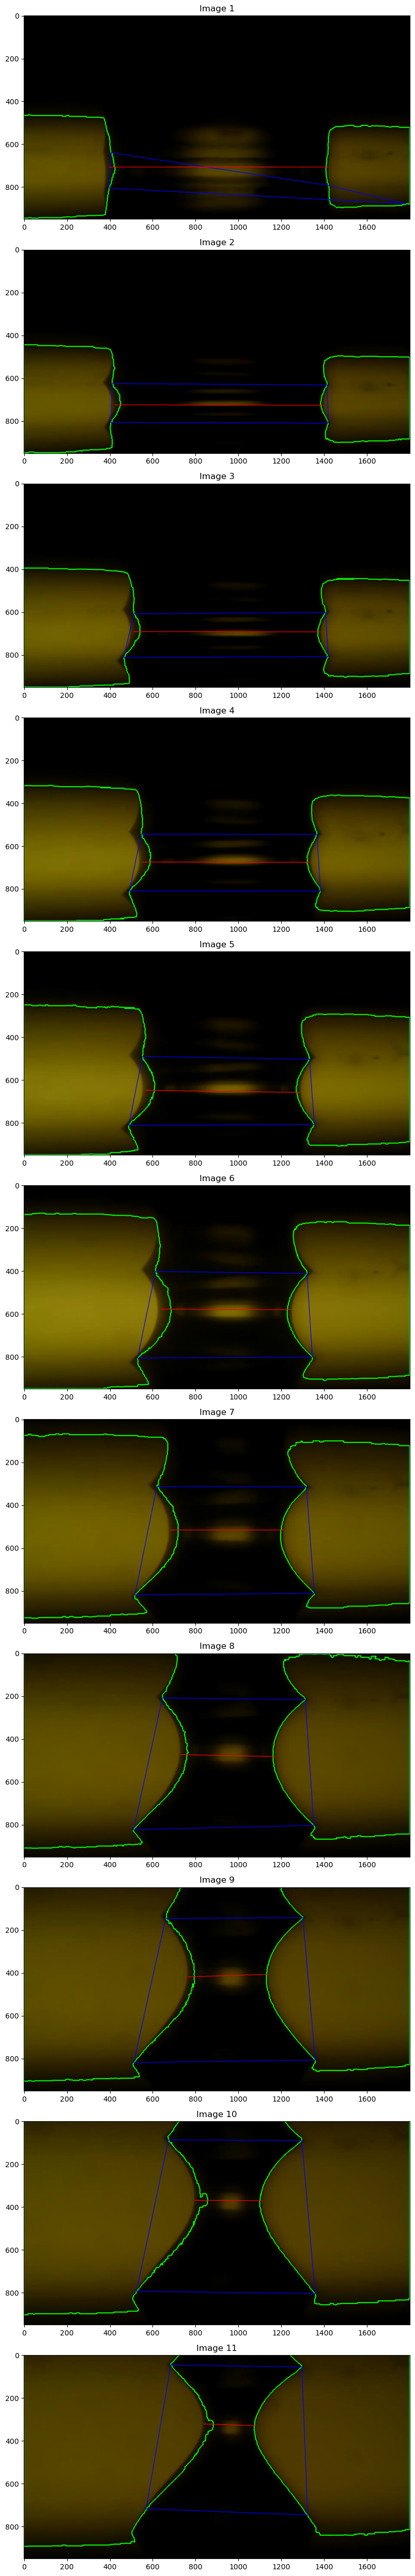

In [135]:
for i, image_sequence in enumerate(all_processed_images):
    plt.figure(figsize=(15, 50))
    
    for j, image in enumerate(image_sequence):
        plt.subplot(len(image_sequence), 1, j + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Image {j + 1}')

    plt.tight_layout()
    plt.savefig(f'results/{IMAGES_DATA[i]["path"].split("/")[1]}.png')
    plt.show()
    plt.close()